# Photosynthesis, multi-leaf tutorial

This tutorial is for analyzing photosynthetic efficiency for multiple leaves.

Created by Katie Murphy & updated by Annika Fischer. Updated July 2025 by Caitlyn Elliott.

Import the necessary packages

In [1]:
#%matplotlib widget
import os
import numpy as np
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

Check the version of your PlantCV

In [2]:
pcv.__version__

'4.10.dev48+g8e81006be.d20250904'

PSII images (3 in a set; F0, Fmin, and Fmax) are captured directly following a saturating fluorescence pulse (red light; 630 nm). These three PSII images can be used to calculate Fv/Fm (efficiency of photosystem II) for each pixel of the plant. 

To run a PSII workflow over a single PSII image set (3 images) there are 4 required inputs:

Image 1: F0 (a.k.a Fdark/null) image.

Image 2: Fmin image.

Image 3: Fmax image.

Output directory: If debug mode is set to 'print' output images from each step are produced.

In practice, PlantCV is directed to these inputs with an INF file, which is referenced in WorkflowInputs below.

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./imgs/PSII_HDR_2023-12-11_B01_1.INF"],
    names="image1",
    result="single-plant-results.json",
    outdir="./example-results",
    writeimg=True,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

## Input data


The CropReporter will output multiple data files, depending on the measurement protocols that are activated on the instrument.

### INF file
**HDR** = the configuration file that describes what measurements were on/off and other settings. This is the input file used by PlantCV

### DAT files
**PSD** = Dark-adapted chlorophyll fluorescence measurements following a saturating light pulse (red light; 630 nm). These images are used to calculate Fv/Fm (efficiency of photosystem II).

**PSL** = Light-adapted chlorophyll fluorescence measurements following a saturating light pulse (red light; 630 nm). These images are used to calculate Fq'/Fm' (operating efficiency of photosystem II).

PSD and PSL are used together to calculate non-photochemical quenching (NPQ).

**CLR** = Blue (475 nm), Green (550 nm), and Red (640 nm) color channels.

**CHL** = Steady-state chlorophyll fluorescence.

**SPC** = Spectral channels used to calculate vegetative indices. Green2 (540 nm), Far-red (710 nm), and Near-infrared (770 nm).

ps is an instance of the PSII_data class in PlantCV. The class stores each available dataset as attributes. The class stores two dataset attributes (datapath and filename) and stores each of the datasets with the following variable names: ojip_dark, ojip_light, chlorophyll, spectral. The ojip_dark, ojip_light, and chlorophyll datasets are stored as xarray DataArrays. The spectral dataset is stored as a PlantCV Spectral_data class instance.

The spectral dataset can contain blue (460nm), green (500nm), red (670nm), green2 (550nm), far-red (700nm), and near-infrared (800nm) frames.


Compiling: PSD
Compiling: PSL
Compiling: CHL
Compiling: CLR
Compiling: SPC


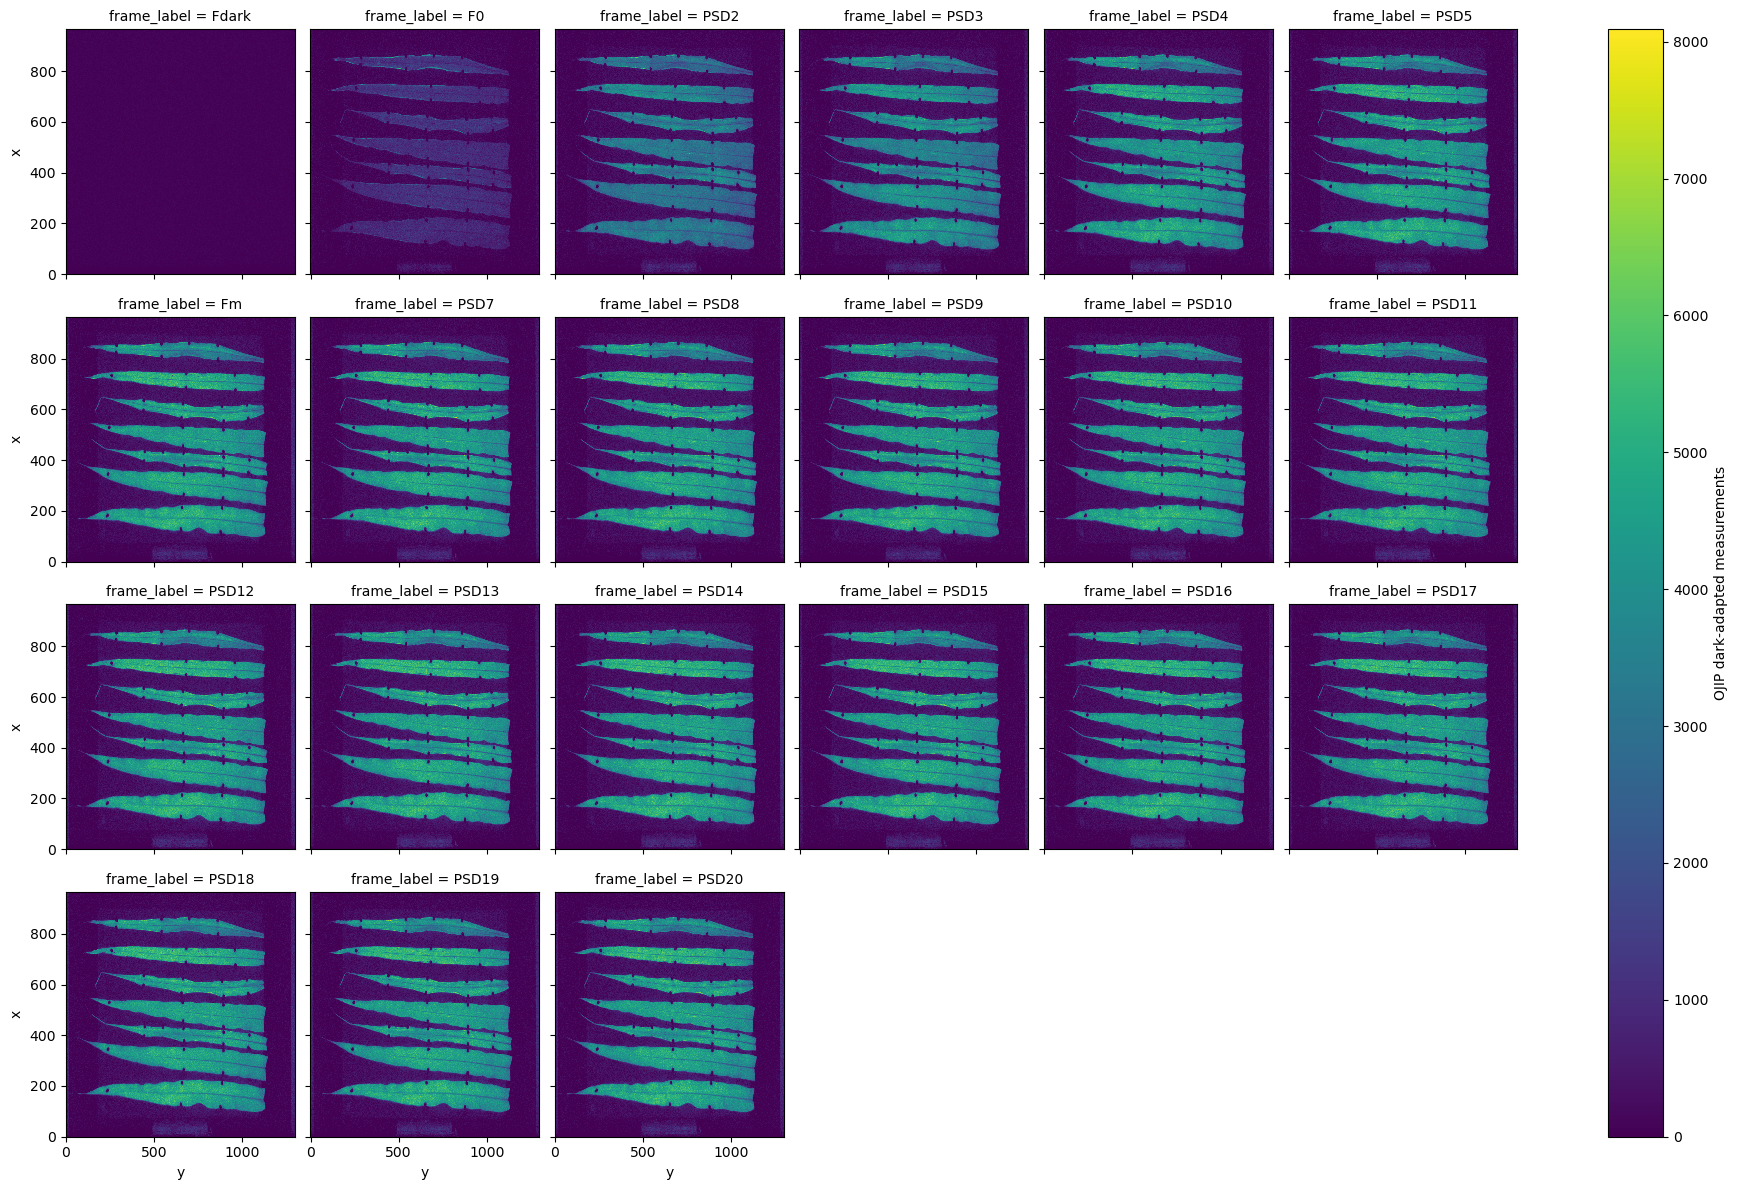

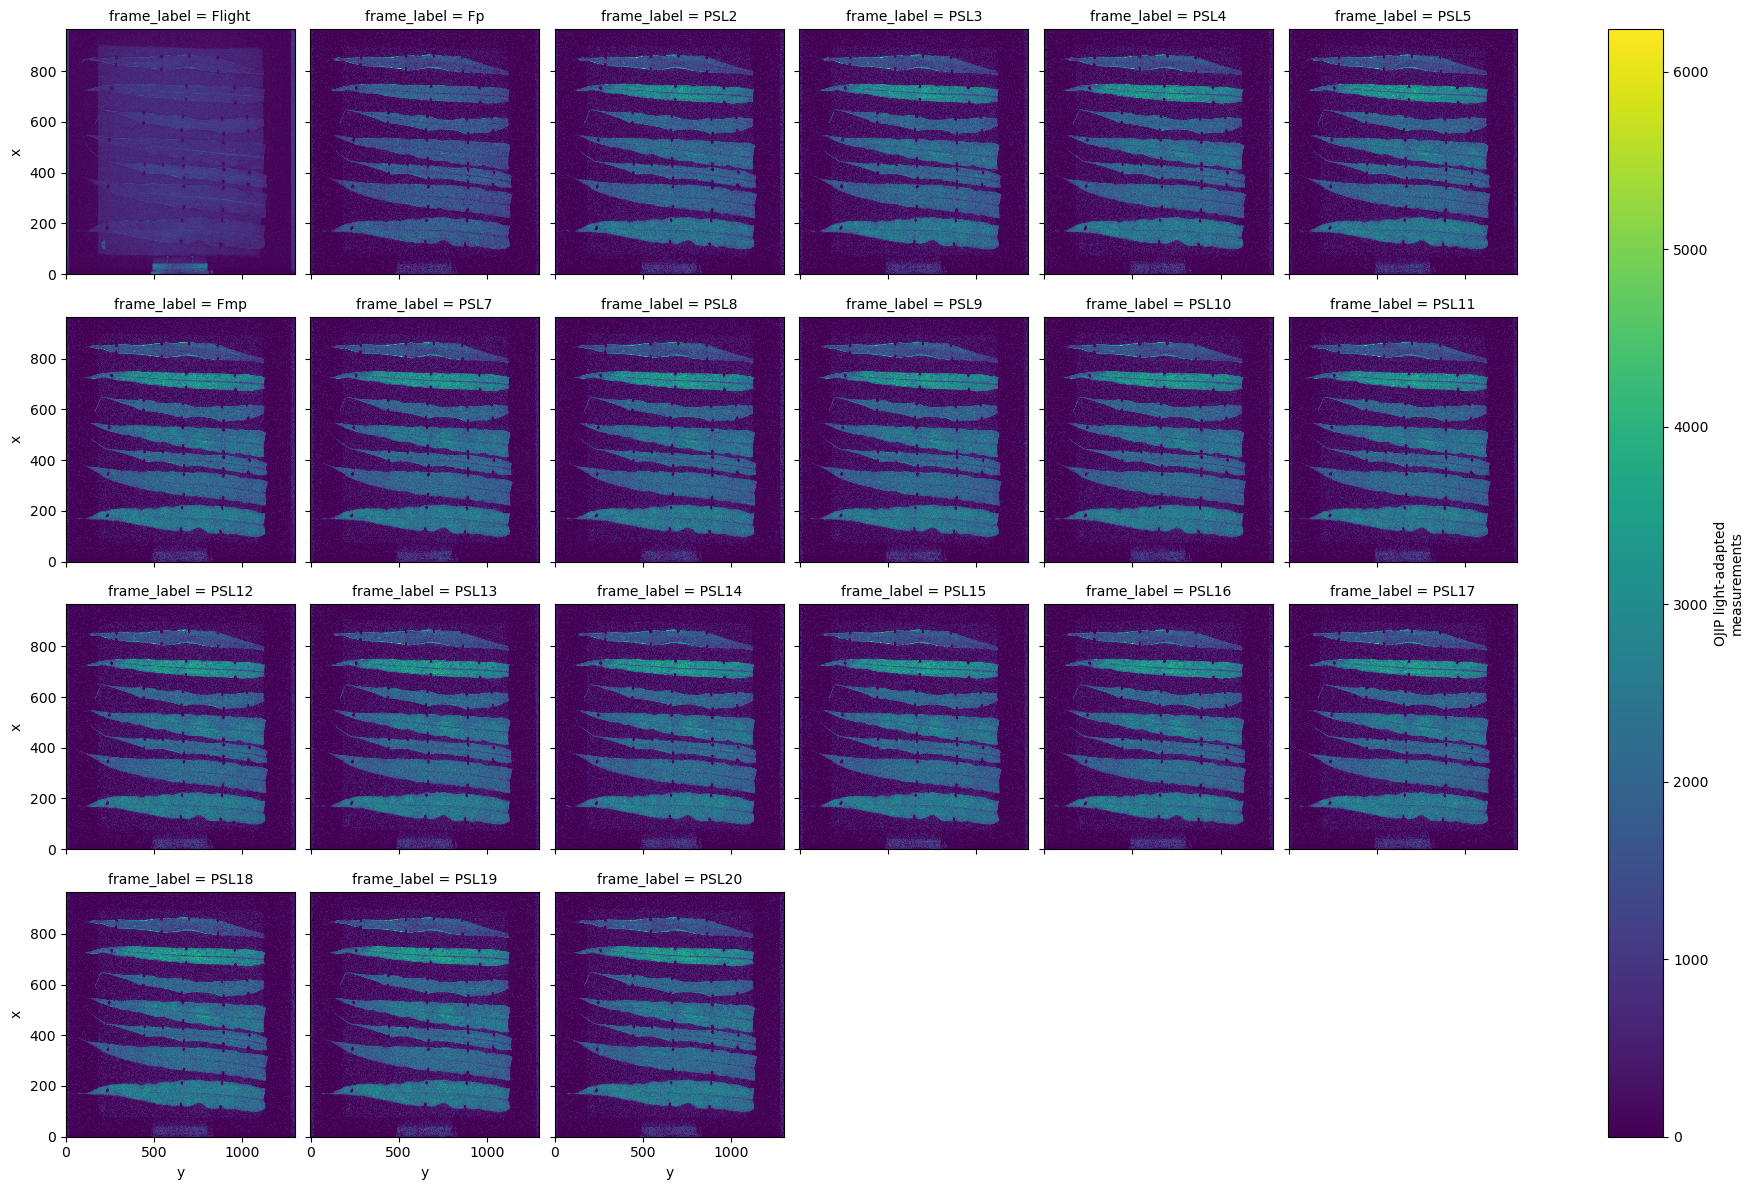

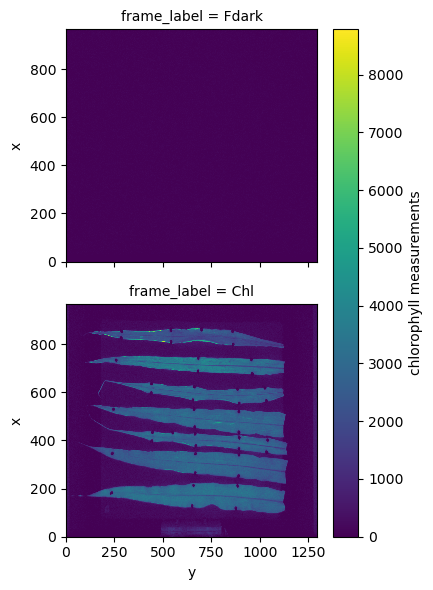

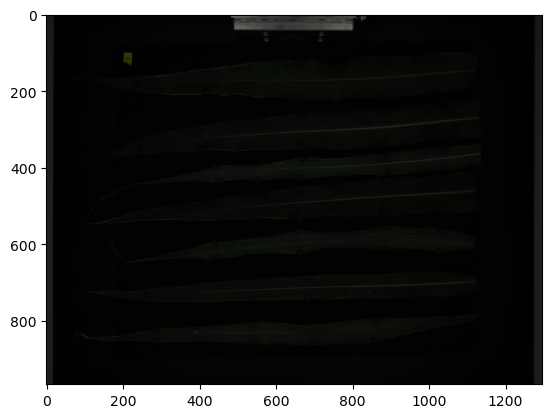

In [5]:
# Read fluorescence image data
# This will visualize all of the frames in all of the data you collected

ps = pcv.photosynthesis.read_cropreporter(filename=args.image1)


## Create a mask

In the code below, we select the chlorophyll "CHL" frame as our grayscale image from which the mask will be created. It is possible to use any frame for creating a mask, but it is easier to use an image with decent contrast between the object of interest (the plant) and the background. 

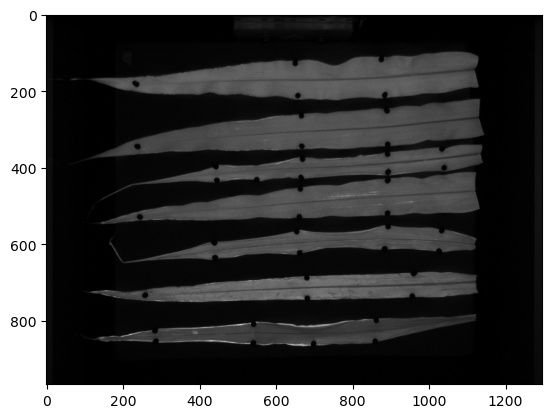

In [6]:
img = ps.chlorophyll.sel(frame_label = "Chl").data
pcv.plot_image(img)

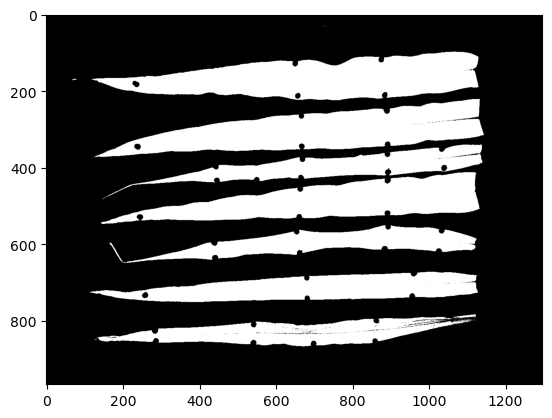

In [7]:
# Segment the chlorophyll image in order to separate the plant from the background

bin_img = pcv.threshold.otsu(gray_img=img, object_type="light")


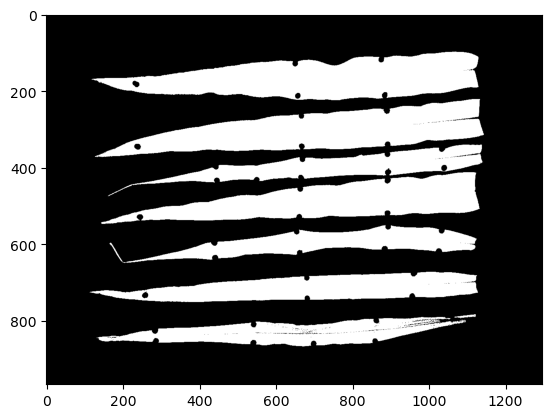

In [8]:
# Fill small objects to remove noise and get a complete plant

filled_mask = pcv.fill(bin_img=bin_img, size=200)


Segmentation accuracy depends largely on the quality of the imaging data collection setup, but the importance of this accuracy also depends on the experimental questiton that a workflow aims to answer. In the case of photosynthesis/fluorescence datasets, it's recommended that segmentation of plants be more conservative. In other words, it's more detrimental for PSII results to have background signal captured within a plant mask than it is to exclude some true plant signal in analysis. Plant movement, reflections within imaging cabinets, and other factors can influence the signal around the edges of an object. To address this, we will preform a morphological erosion to remove the edges.  

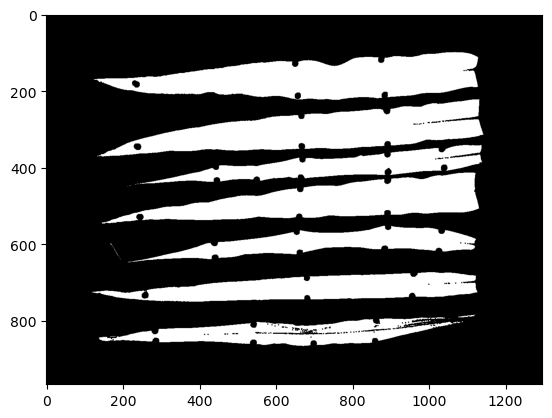

In [9]:
# Erode a small border of pixels from the mask 

eroded_mask = pcv.erode(gray_img=filled_mask, ksize=3, i=1)


## Set object labels 
Label each object according to the known identity. 

It's possible to use a text/csv file with ID names rather than hard coding into a workflow.

In [10]:
# Sample label list
labels = ["Floor-Pot_1", "Floor-Pot_2", "Floor-Pot_3", "Floor-Pot_4", "Floor-Pot_5", "Floor-Pot_6","Floor-Pot_7"]

## OR (new) import list of labels from a text file (or csv, whatever)
labels = (np.loadtxt("./2023-12-11_B01_1.txt", dtype=str)).tolist()
print(labels)

['Floor-Pot_1,', 'Floor-Pot_2,', 'Floor-Pot_3,', 'Floor-Pot_4,', 'Floor-Pot_5,', 'Floor-Pot_6,', 'Floor-Pot_7']


## Create Regions of Interest to separate plants 

Note: number of rows in the code below assumes number of labels and number of ROIs to be equal. Need to parameterize `rows` directly if not true. 

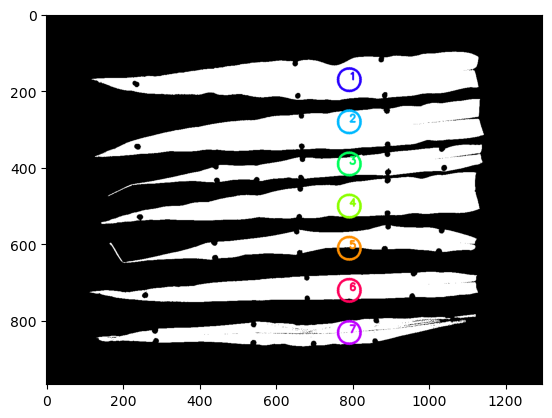

In [11]:
## Update debugging parameters for more readability of ROI labels
pcv.params.text_size = 0.9
pcv.params.text_thickness = 3

# Usually need to set the number of rows to detect, but can possibly assume there are as many plants as labels.
rows = len(labels)
# Automatically place ROIs on each plant to separate
auto_rois = pcv.roi.auto_grid(img=filled_mask, mask=eroded_mask, ncols=1, nrows=rows, radius=30)

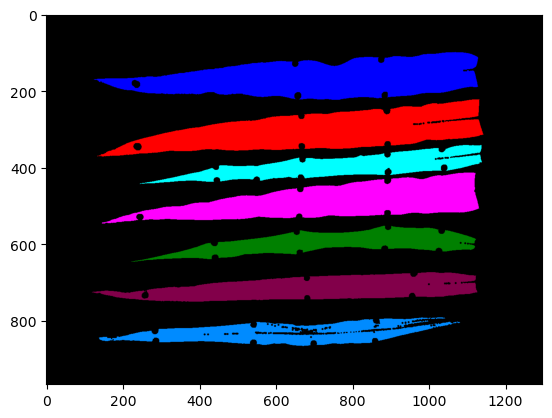

In [12]:
# Create a labeled mask

labeled_mask, n_labels = pcv.create_labels(mask=eroded_mask, rois=auto_rois)

## Phenotypic measurements

Label each object according to the known identity. 

It's possible to use a text/csv file with ID names rather than hard coding into a workflow.

In [13]:
# Sample label list
labels = ["Floor-Pot_1", "Floor-Pot_2", "Floor-Pot_3", "Floor-Pot_4", "Floor-Pot_5", "Floor-Pot_6","Floor-Pot_7"]

## OR (new) import list of labels from a text file (or csv, whatever)
labels = (np.loadtxt("./2023-12-11_B01_1.txt", dtype=str)).tolist()
print(labels)

['Floor-Pot_1,', 'Floor-Pot_2,', 'Floor-Pot_3,', 'Floor-Pot_4,', 'Floor-Pot_5,', 'Floor-Pot_6,', 'Floor-Pot_7']


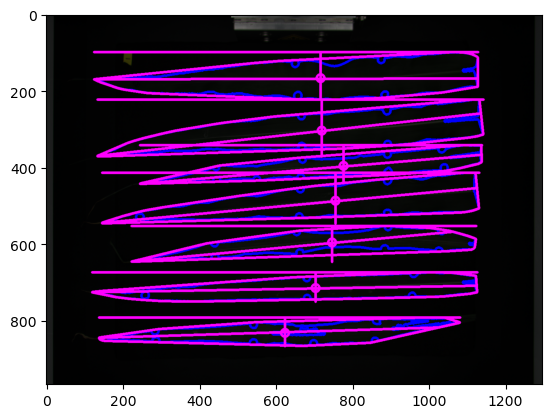

In [14]:
# Analyze shape and size of each leaf
shape_img = pcv.analyze.size(img=ps.spectral.pseudo_rgb, labeled_mask=labeled_mask, n_labels=n_labels, label=labels)

### Visualize the chlorophyll fluorescence induction curves (optional)

In this experiment, the leaves were dark-adapted. An image is taken of the leaves in the dark (F-dark). The leaves were then exposed to a saturating red light pulse briefly. An image of chlorophyll fluorescence is taken immediately after the pulse to measure minimal fluorescence (F0). Successive images are taken at a fixed time interval (20 total frames from F0 to F19 in this example). Here we will chart the induction curves using visualize.chlorophyll_fluorescence to see if the maximum fluorescence frames are set at a reasonable place or whether we want to adjust them in a later step.

In [15]:
# Dark-adapted fluorescence induction curve
# This curve is only for the object in your kept mask from above

dark_fig = pcv.visualize.chlorophyll_fluorescence(ps_da=ps.ojip_dark, labeled_mask=labeled_mask, n_labels=n_labels)

alt.LayerChart(...)

After the Fv/Fm protocol, the leaves are light-adapted. An image is taken of the leaves in the light (F-light). The leaves are then exposed to an actinic light, and an image of chlorophyll fluorescence is taken to measure steady-state fluorescence (F'). The leaves are then exposed to a saturating red light pulse briefly. Successive images are taken at a fixed time interval (20 total frames from F0 to F19 in this example). Here we will use the visualize.chlorophyll_fluorescence function to chart the fluorescence induction curve.

In [16]:
# Light-adapted fluorescence induction curve

light_fig = pcv.visualize.chlorophyll_fluorescence(ps_da=ps.ojip_light, labeled_mask=labeled_mask, n_labels=n_labels)

alt.LayerChart(...)

# Estimate the efficiency of PSII

Using the dark-adapted and light-adapted datasets, calculate the metric Fv/Fm to estimate the maximum efficiency of PSII and the metric Fq'/Fm' to estimate the operating efficiency of PSII. In both cases the function analyze.yii is used. Setting auto_fm=True will use photosynthesis.reassign_frame_labels to automatically find the frame with the maximum fluorescence for each masked region.

alt.FacetChart(...)

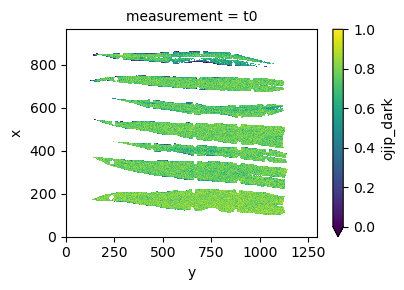

In [17]:
# Analyze Fv/Fm

fvfm, fvfm_hist = pcv.analyze.yii(ps_da=ps.ojip_dark, labeled_mask=labeled_mask, n_labels=n_labels, auto_fm=True,
                                  measurement_labels=["Fv/Fm"], label=labels)


alt.FacetChart(...)

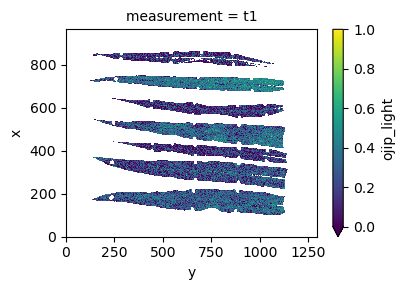

In [18]:
# Analyze Fq'/Fm'

fqfm, fqfm_hist = pcv.analyze.yii(ps_da=ps.ojip_light, labeled_mask=labeled_mask, n_labels=n_labels, auto_fm=True,
                                  measurement_labels=["Fq'/Fm'"], label=labels)

# Estimate non-photochemical quenching 

Nonphotochemical quanching (NPQ) can be estimated using the analyze.npq function.

alt.FacetChart(...)

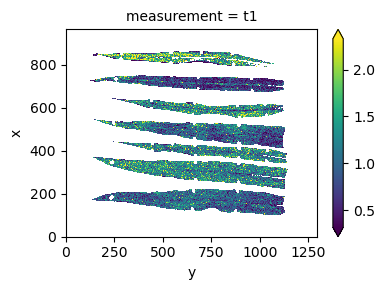

In [19]:
# Analyze NPQ


npq, npq_hist = pcv.analyze.npq(ps_da_light=ps.ojip_light, ps_da_dark=ps.ojip_dark, labeled_mask=labeled_mask, n_labels=n_labels,
                                auto_fm=True, measurement_labels=["NPQ"], label=labels, max_bin=10)

Optionally, the Fv/Fm, Fq'/Fm', and NPQ images can be visualized using the pseudocolor function to assess the distribution of values across the leaves.

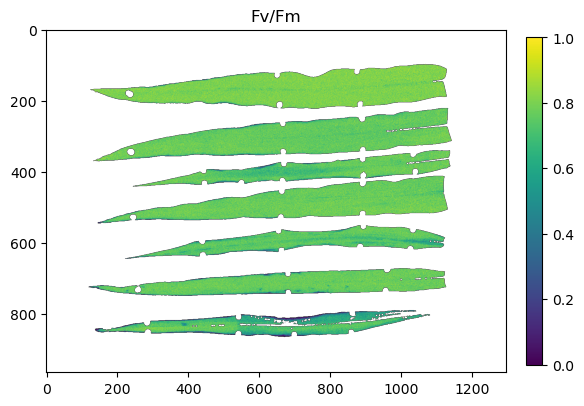

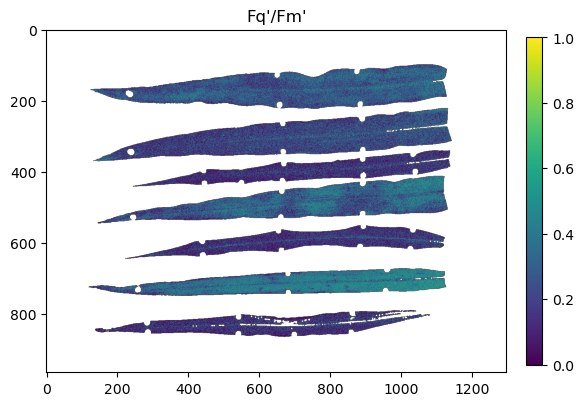

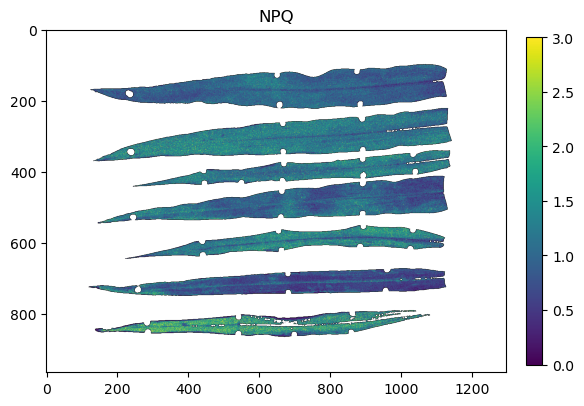

In [20]:
# Pseudocolor the PSII metric images

fvfm_cmap = pcv.visualize.pseudocolor(gray_img=fvfm, mask=filled_mask, cmap="viridis", 
                                        min_value=0, max_value=1, title="Fv/Fm")
fqfm_cmap = pcv.visualize.pseudocolor(gray_img=fqfm, mask=filled_mask, cmap="viridis", 
                                        min_value=0, max_value=1, title="Fq'/Fm'")
npq_cmap = pcv.visualize.pseudocolor(gray_img=npq, mask=filled_mask, cmap="viridis", 
                                        min_value=0, max_value=3, title="NPQ")

# Analyze spectral indices

# Anthocyanin Reflectance Index
Calculate ARI using the ari function, plot a colormap, and analyze the leaf values.

/home/josh/plantcv/plantcv/plantcv/transform/rescale.py:30: RuntimeWarning: invalid value encountered in cast
  rescaled_img = (rescaled_img).astype('uint8')


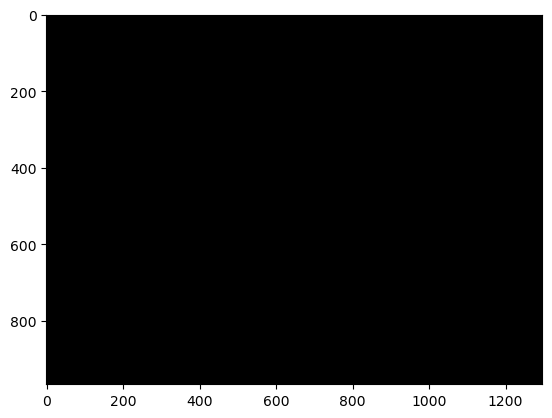

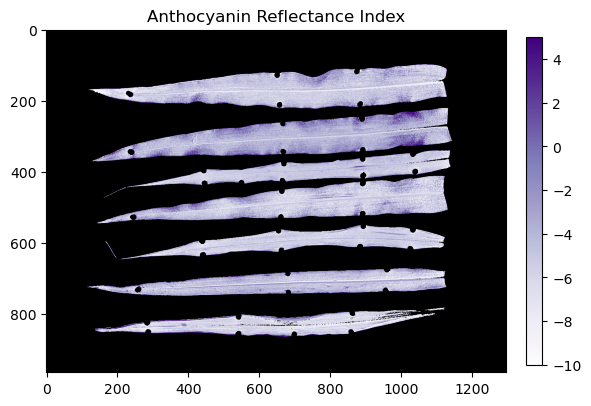

alt.FacetChart(...)

In [21]:
# Calculare the Anthocyanin Reflectance Index.
ari = pcv.spectral_index.ari(hsi=ps.spectral)

# Visualize with pseudocolor
ari_ps = pcv.visualize.pseudocolor(gray_img=ari.array_data, min_value=-10, max_value=5, 
                                    cmap="Purples", mask=filled_mask, background="black", 
                                    title="Anthocyanin Reflectance Index")

# Analyze frequency data of the index
ari_hist = pcv.analyze.spectral_index(index_img=ari, labeled_mask=labeled_mask, n_labels=n_labels, min_bin=-10, max_bin=5, label=labels)


# Chlorophyll Index Red Edge

Calculate CI using the ci_rededge function, plot a colormap, and analyze the leaf values.

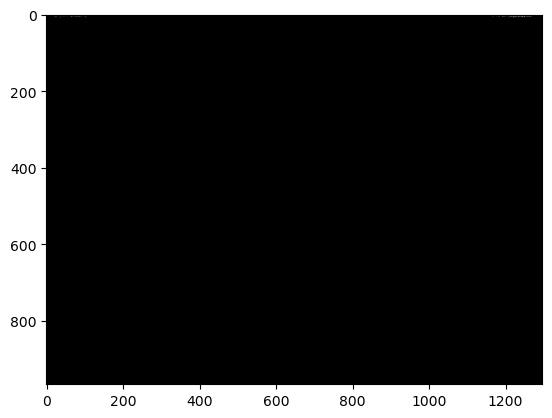

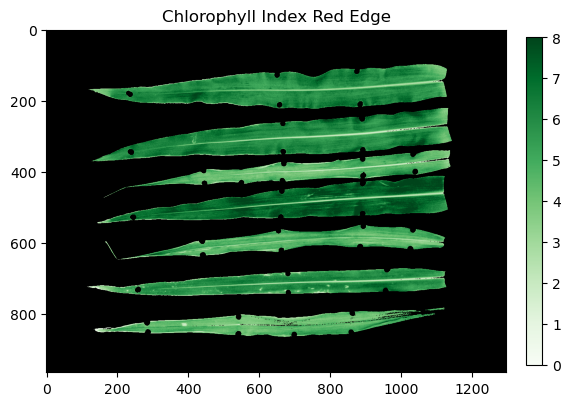

alt.FacetChart(...)

In [22]:

ci = pcv.spectral_index.ci_rededge(hsi=ps.spectral, distance=30)

ci_ps = pcv.visualize.pseudocolor(gray_img=ci.array_data, min_value=0, max_value=8, 
                                    cmap="Greens", mask=filled_mask, background="black", 
                                    title="Chlorophyll Index Red Edge")

ci_hist = pcv.analyze.spectral_index(index_img=ci, labeled_mask=labeled_mask, n_labels=n_labels, min_bin=0, max_bin=12, label=labels)

# Normalized Difference Vegetation Index
Calculate NDVI using the ndvi function, plot a colormap, and analyze the leaf values.

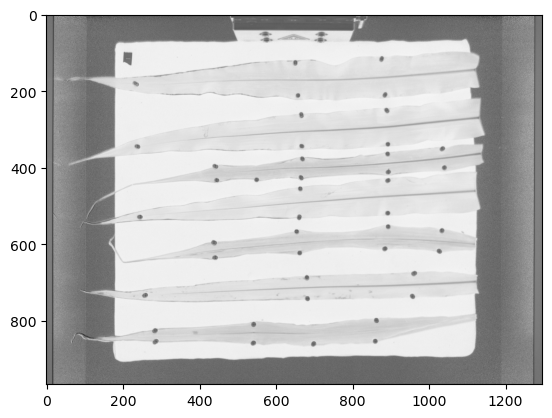

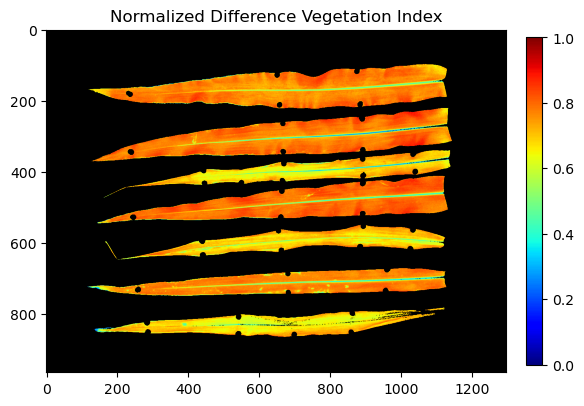

alt.FacetChart(...)

In [23]:

ndvi = pcv.spectral_index.ndvi(hsi=ps.spectral, distance=30)

ndvi_ps = pcv.visualize.pseudocolor(gray_img=ndvi.array_data, min_value=0, max_value=1, 
                                    cmap="jet", mask=filled_mask, background="black", 
                                    title="Normalized Difference Vegetation Index")

ndvi_hist = pcv.analyze.spectral_index(index_img=ndvi, labeled_mask=labeled_mask, n_labels=n_labels, min_bin=0, max_bin=1, label=labels)


# Save results and finish the workflow¶
The save results function will take the measurements stored when running any PlantCV analysis functions, format, and print an output text file for data analysis. 

In [24]:

pcv.outputs.save_results(filename=args.result)

if args.writeimg:
    pcv.print_image(img=dark_fig, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fvfm_induction.png"))
    pcv.print_image(img=light_fig, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fqfm_induction.png"))
    pcv.print_image(img=fvfm_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fvfm_histogram.png"))
    pcv.print_image(img=fqfm_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fqfm_histogram.png"))
    pcv.print_image(img=npq_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_npq_histogram.png"))
    pcv.print_image(img=fvfm_cmap, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fvfm_cmap.png"))
    pcv.print_image(img=fqfm_cmap, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_fqfm_cmap.png"))
    pcv.print_image(img=npq_cmap, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_npq_cmap.png"))
    pcv.print_image(img=ari_ps, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ari_cmap.png"))
    pcv.print_image(img=ari_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ari_hist.png"))
    pcv.print_image(img=ci_ps, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ci_cmap.png"))
    pcv.print_image(img=ci_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ci_hist.png"))
    pcv.print_image(img=ndvi_ps, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ndvi_cmap.png"))
    pcv.print_image(img=ndvi_hist, filename=os.path.join(args.outdir, f"{ps.filename[:-4]}_ndvi_hist.png"))


In [25]:
# Clear the measurements stored globally into the Ouptuts class

pcv.outputs.clear()